# Vanishing/Exploding Gradients Problem

## Glorot and He Initialization

In [4]:
import torch
import torch.nn as nn

layer = nn.Linear(40, 10)
layer.weight.shape

torch.Size([10, 40])

In [5]:
layer.weight.data[0] 

tensor([ 0.0031, -0.0553,  0.1199, -0.0687, -0.0569,  0.1145, -0.1544,  0.0588,
         0.0453, -0.0511,  0.1396,  0.1391,  0.1229,  0.0197,  0.0849, -0.0799,
        -0.1532, -0.0577,  0.0382, -0.1125,  0.0491,  0.0354, -0.0621,  0.1511,
        -0.0100, -0.0394, -0.0674, -0.0295, -0.0391,  0.0857,  0.0319, -0.1510,
         0.1568,  0.1515, -0.0783, -0.1184, -0.0896,  0.1301,  0.0737,  0.1429])

In [6]:
layer.weight.data *= 6**0.5  # He init

In [7]:
layer.weight.data[0]

tensor([ 0.0076, -0.1355,  0.2938, -0.1683, -0.1393,  0.2806, -0.3782,  0.1440,
         0.1110, -0.1253,  0.3420,  0.3408,  0.3010,  0.0483,  0.2079, -0.1956,
        -0.3753, -0.1414,  0.0935, -0.2756,  0.1204,  0.0868, -0.1522,  0.3701,
        -0.0246, -0.0965, -0.1652, -0.0724, -0.0957,  0.2100,  0.0781, -0.3699,
         0.3842,  0.3712, -0.1918, -0.2899, -0.2195,  0.3186,  0.1805,  0.3500])

In [8]:
layer.bias.data

tensor([ 0.1438, -0.0571,  0.0083, -0.0700,  0.0546,  0.0472, -0.0023, -0.1571,
         0.0165,  0.0189])

In [9]:
torch.zero_(layer.bias.data)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [10]:
layer = nn.Linear(40, 10)
nn.init.kaiming_uniform_(layer.weight)
nn.init.zeros_(layer.bias)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

In [11]:
def use_he_init(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_uniform_(module.weight)
        nn.init.zeros_(module.bias)
model = nn.Sequential(nn.Linear(40, 30), nn.ReLU(), nn.Linear(30, 1), nn.ReLU())
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=40, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
  (3): ReLU()
)

In [12]:
model = nn.Sequential(nn.Linear(40, 10), nn.LeakyReLU(negative_slope=0.2))  # alpha is negative slope
model.apply(use_he_init)

Sequential(
  (0): Linear(in_features=40, out_features=10, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
)

## Better Activation Functions

### Leaky ReLU

In [15]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

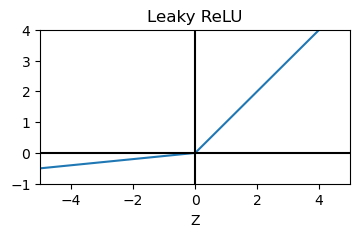

In [16]:
import numpy as np
import matplotlib.pyplot as plt

z = np.linspace(-5, 5, 200)
plt.figure(figsize=(4,2))
plt.plot(z, leaky_relu(z,0.1) , "-")
plt.plot([-5,5] ,[0,0] , "k-")
plt.plot([0,0] ,[-1,4] , "k-")
plt.axis([-5, 5 , -1, 4])
plt.title("Leaky ReLU")
plt.xlabel("Z")
plt.axis()
plt.show()

In [17]:
torch.manual_seed(42)
alpha = 0.2
model = nn.Sequential(nn.Linear(50, 40), nn.LeakyReLU(negative_slope=alpha))
nn.init.kaiming_uniform_(model[0].weight, alpha, nonlinearity="leaky_relu")
model(torch.rand(2,50)).shape

torch.Size([2, 40])

## Batch Normalization

In [19]:
class MyBatchNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super().__init__()
        self.eps = eps
        self.momentum = momentum

        #Learning Parameters
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

        #Running stats (for inference time)
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

    def forward(self, X):
        if self.training:
            batch_mean = X.mean(dim=0)
            batch_var = X.var(dim=0, unbiased=False)  # by default sample variance(1/N-1),now population variance(1/N)
            
            #Normalize
            X_hat = (X - batch_mean) / torch.sqrt(batch_var + self.eps)

            #Update running stats
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * batch_mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * batch_var
        else:
            X_hat = (X - self.running_mean) / torch.sqrt(self.running_var + self.eps)

        out = self.gamma * X_hat + self.beta
        return out

In [20]:
torch.manual_seed(42)
model1 = nn.Sequential(
    nn.Flatten(),
    MyBatchNorm(1 * 28 * 28),
    nn.Linear(1 * 28 * 28, 300),
    nn.ReLU(),
    MyBatchNorm(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    MyBatchNorm(100),
    nn.Linear(100, 10)
)

In [21]:
dict(model1[1].named_parameters()).keys()

dict_keys(['gamma', 'beta'])

In [22]:
dict(model1[1].named_buffers()).keys()

dict_keys(['running_mean', 'running_var'])

In [23]:
torch.manual_seed(42)

model1.train()
x = torch.randn(2,28,28)   
out = model1(x)
out.round(decimals=2)

tensor([[ 0.0200,  1.4500, -0.3600,  0.6600, -0.6800,  0.7700,  0.2500,  0.9700,
          0.0800,  0.8100],
        [ 0.0500, -1.2900,  0.2600, -0.6900,  0.8400, -0.6300, -0.1700, -1.1300,
         -0.0000, -0.6600]], grad_fn=<RoundBackward1>)

In [24]:
torch.manual_seed(42)
model2 = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(1 * 28 * 28),
    nn.Linear(1 * 28 * 28, 300),
    nn.ReLU(),
    nn.BatchNorm1d(300),
    nn.Linear(300, 100),
    nn.ReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 10)
)

In [25]:
dict(model2[1].named_parameters()).keys()

dict_keys(['weight', 'bias'])

In [26]:
torch.manual_seed(42)

model2.train()
x = torch.randn(2,28,28)   
out = model2(x)
out.round(decimals=2)

tensor([[ 0.0200,  1.4500, -0.3600,  0.6600, -0.6800,  0.7700,  0.2500,  0.9700,
          0.0800,  0.8100],
        [ 0.0500, -1.2900,  0.2600, -0.6900,  0.8400, -0.6300, -0.1700, -1.1300,
         -0.0000, -0.6600]], grad_fn=<RoundBackward1>)

## Layer Normalization

In [28]:
class MyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.normalized_shape = normalized_shape

        #Learning Parameters
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, X):
        dims = tuple(range(-len(self.normalized_shape),0))
        mean = X.mean(dim=dims, keepdim=True)
        var = X.var(dim=dims, unbiased=False, keepdim=True)
        X_hat = (X - mean) / torch.sqrt(var + self.eps)
        return self.gamma * X_hat + self.beta           

In [29]:
torch.manual_seed(42)

inputs = torch.randn(32, 4, 100, 200)
layer_norm = MyLayerNorm([100,200])
result1 = layer_norm(inputs)

In [30]:
torch.manual_seed(42)

inputs = torch.randn(32, 4, 100, 200)
layer_norm = nn.LayerNorm([100,200])
result2 = layer_norm(inputs)

In [31]:
assert torch.allclose(result1, result2)

In [32]:
layer_norm = MyLayerNorm([32, 4, 100, 200])
result3 = layer_norm(inputs)

In [33]:
layer_norm = nn.LayerNorm([32, 4, 100, 200])
result4 = layer_norm(inputs)
assert torch.allclose(result3, result4)

## Gradient Clipping

### Value Clipping

In [36]:
grad = torch.tensor([10.0, -5.0, 2.0, 8.0])
clip_value = 3.0
grad_value_clipped = torch.clamp(grad, min= -clip_value, max=clip_value)
grad_value_clipped

tensor([ 3., -3.,  2.,  3.])

In [37]:
param = nn.Parameter(torch.tensor([10.0, -5.0, 2.0, 8.0]))
param.grad = torch.tensor([10.0, -5.0, 2.0, 8.0])
nn.utils.clip_grad_value_([param], clip_value=3.0)
param.grad

tensor([ 3., -3.,  2.,  3.])

### Norm Clipping

In [39]:
max_norm = 3.0
grad_norm = torch.sqrt(torch.sum(grad**2))
grad_norm

tensor(13.8924)

In [40]:
if grad_norm > max_norm:
    scale = max_norm / grad_norm
    grad_norm_clipped = grad * scale
else:
    grad_norm_clipped = grad

grad_norm_clipped

tensor([ 2.1594, -1.0797,  0.4319,  1.7276])

In [41]:
param = nn.Parameter(torch.tensor([10.0, -5.0, 2.0, 8.0]))
param.grad = torch.tensor([10.0, -5.0, 2.0, 8.0])
nn.utils.clip_grad_norm_([param], max_norm=3.0)
param.grad

tensor([ 2.1594, -1.0797,  0.4319,  1.7276])